In [1]:
import pandas as pd
import numpy as np
from IPython.display import display_html
import matplotlib.pyplot as plt
import numpy as np
import xlsxwriter
import math
from sklearn.cluster import KMeans
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def convert_excel(path, sheet_name = 'Ark1', pri = True):
    df = pd.read_excel(path, sheet_name)
    if pri:
        print('The first 5 rows of the loaded data:')
        display_html(df.head())
    return df

def choose_headers(df, headers_list, pri):
    temp_df = pd.DataFrame()
    for i in range(len(headers_list)):
        if pri:
            print('Choosing the column "', headers_list[i], '"')
        temp_df = pd.concat([temp_df, df[headers_list[i]]], axis = 1)
    return temp_df

def remove_nan(df):
    df = df.dropna().reset_index(drop=True)
    return df

def choose_subsets(df, column_str_list, subset_str_list, pri):
    temp_df = pd.DataFrame()
    for i in range(len(column_str_list)):
        if pri:
            print('Choosing the rows with "', subset_str_list[i], '" in the "', column_str_list[i], '" column.')
        temp_df = pd.concat([temp_df, df[df[column_str_list[i]] == subset_str_list[i]]])
    return temp_df

# Function to convert the dataframe back into an excel sheet.
# More options will follow if there needs to be more sheets etc.
# Inputs: Dataframe as converted by convert_excel, the name you wish the excel file to have (remember .xlsx)
def convert_dataframe(df, name_str):
    file = df.to_excel(name_str, index=False)



## Strategi for data:
- Identificer hvor mange patenter fra de forskellige lande (forskel mellem længden af DK patenter fundet her og miljøteknologi dataen "på tværs af teknikområder"). **DONE**
- Hvor mange virksomheder er disse patenter spredt over, hvilke virksomheder står for størstedelen af patenterne? Sammenlign dette med størrelsen af virksomheden. Er der nogen virksomheder som stikker ud i forhold til at de er en lille virksomhed, men med mange patentansøgninger og vice versa? **GØR DETTE FOR DK** **SPURGT EMIL**
- Hvilke år har været gode? Har f.eks. corona påvirket dette? **DONE**
- Gruppér lande pba deres patentsøgninger indenfor de forskellige teknikområder.
- HUSK AT KIGGE PÅ PATENTER PR. 100.000 INDBYGGERE. **DONE**
- Kan de andre kolonner bruges til noget? "publn_auth", "family_id", "publn_nr"? 
- Måske noget med eu_members
- Kig efter hvor danmark har flest patenter, hvilke teknikområder

In [3]:
df_rådata = convert_excel("Miljøteknologi rådata.xlsx", sheet_name="DATA_til_eksport_v2", pri=False)
df_countrycodes = convert_excel("Countrycodes.xlsx", sheet_name="Countrycodes", pri=False)
df_populations = convert_excel("world_population.xlsx", sheet_name="world_population", pri=False)

In [4]:
df_rådata
temp = df_rådata["person_ctry_code"].unique()

In [5]:
df_rådata = df_rådata[df_rådata.earliest_publn_year != 2022]

In [8]:
df_dk = choose_subsets(df_rådata, ["person_ctry_code"], ["DK"], True)
len(df_dk)

Choosing the rows with " DK " in the " person_ctry_code " column.


1451

In [9]:
print("There are ", len(df_dk["psn_name"].unique()), " different companies who requested a patent in the years 2011 - 2022 from Denmark")

There are  313  different companies who requested a patent in the years 2011 - 2022 from Denmark


In [10]:
print("There are ", len(df_rådata["person_ctry_code"].unique()), " different countries in the data")

There are  90  different countries in the data


In [11]:
set(list(temp))-set(list(df_rådata["person_ctry_code"].unique()))

{'IS', 'SM', 'UA'}

## Omdanner rådata til at være patenter pr. 100.000 indbyggere

### Mapper navnene fra countrycodes over til udskrevne navne (Her er der nogen som får et lidt mærkeligt navn, det bliver addresseret senere)

In [12]:
list1 = list(df_countrycodes["Column2"])
list2 = list(df_countrycodes["Column1"])

In [13]:
replacement_map = {l1: l2 for l1, l2 in zip(list1, list2)}
df_rådata["person_ctry_code"] = df_rådata["person_ctry_code"].map(replacement_map)

In [14]:
pop = df_populations[["Country/Territory","2022 Population"]]
pop["Population / 100000"] = pop["2022 Population"]/100000

In [15]:
patents = df_rådata.groupby(["person_ctry_code"]).size()

In [16]:
pop = choose_subsets(pop, ["Country/Territory" for i in range(len(list(patents.keys())))], list(patents.keys()), pri=False)

##### Der er pt kun 88 af landende som kommer videre fra dataframen, ud af de 93 der er i rådata. (navneforskel)?

In [17]:
list(set(list(patents.keys()))-set(list(pop["Country/Territory"])))

['Korea, Republic of',
 'Virgin Islands, British',
 'CuraÃ§ao',
 'Russian Federation',
 'Taiwan, Province of China']

##### Manuel tilføjelse af de sidste 5 til dataen

In [18]:
pop.loc[1000] = ["Taiwan", 23893394, 23893394/100000]
pop.loc[1001] = ["Curacao", 191163, 191163/100000]
pop.loc[1002] = ["South Korea", 51815810, 51815810/100000]
pop.loc[1003] = ["Russia", 144713314, 144713314/100000]
pop.loc[1004] = ["United States Virgin Islands", 99465, 99465/100000]

### Nu indeholder "pop" 93 lande, som stemmer overens med de 93 unikke lande der indgår i patentdataen. I "pop" er der population og population/100000

## Hvilke lande har flest patentansøgninger pr. 100.000 indbyggere

In [19]:
df_rådata['person_ctry_code'] = df_rådata['person_ctry_code'].str.replace("Virgin Islands, British","United States Virgin Islands")
df_rådata['person_ctry_code'] = df_rådata['person_ctry_code'].str.replace("CuraÃ§ao","Curacao")
df_rådata['person_ctry_code'] = df_rådata['person_ctry_code'].str.replace("Korea, Republic of","South Korea")
df_rådata['person_ctry_code'] = df_rådata['person_ctry_code'].str.replace("Taiwan, Province of China","Taiwan")
df_rådata['person_ctry_code'] = df_rådata['person_ctry_code'].str.replace("Russian Federation","Russia")

In [20]:
#convert_dataframe(df_rådata, "Miljøteknologi rådata_new.xlsx")

In [21]:
pop = pop.sort_values(by="Country/Territory")

In [62]:
df_rådata_companies = df_rådata.groupby(["person_ctry_code", "psn_name"]).size()

In [60]:
df_rådata_companies

person_ctry_code              psn_name                                                                            
Algeria                       UNIVERSITE ABDERRAHMANE MIRA                                                             2
Andorra                       NOMEN CALVET, JUAN EUSEBIO                                                               1
                              WGA WATER GLOBAL ACCESS S.L.                                                             3
Argentina                     CABELLO, JULIETA VIRGINIA                                                                1
                              CHAN, RAQUEL LIA                                                                         1
                                                                                                                      ..
United States Virgin Islands  SCHLUMBERGER HOLDINGS                                                                   25
                              SPRING P

In [64]:
df_rådata_companies.loc["Finland"].sort_values(ascending=False)[0:10].reset_index()

,psn_name,0
0,NESTE,161
1,OUTOTEC (FINLAND),158
2,KEMIRA,151
3,UPM-KYMMENE CORPORATION,122
4,MARICAP,99
5,STORA ENSO,70
6,WAERTSILAE FINLAND,57
7,OUTOTEC,57
8,VALTION TEKNILLINEN TUTKIMUSKESKUS,47
9,NESTE OIL,46


#### Antallet af patenter pr. 100.000 indbyggere:

In [20]:
len(list(df_rådata.groupby(["person_ctry_code"]).size().index))

90

In [21]:
num_patents = list(df_rådata.groupby(["person_ctry_code"]).size().values)
num_100000 = list(pop["Population / 100000"])
res = [i / j for i, j in zip(num_patents, num_100000)]
df_patents = pd.DataFrame(list(df_rådata.groupby(["person_ctry_code"]).size().index))
df_patents = df_patents.rename(columns = {0:"Country"})
df_patents["2022 Inhabitants"] = list(pop["2022 Population"])
df_patents["patents/(inhabitants/100000)"] = res
df_patents["patents"] = num_patents
df_patents['Highlight'] = df_patents['Country'].apply(lambda x: x == "Denmark")

In [22]:
df_patents['Highlight'] = df_patents['Country'].apply(lambda x: x == "Denmark")

In [23]:
tax_havens = ["Luxembourg", "United States Virgin Islands", "Monaco", "Cook Islands", "Liechtenstein", "Cayman Islands"]
for haven in tax_havens:
    df_patents.drop(df_patents[df_patents['Country'] == haven].index, inplace = True)

In [24]:
df_patents = df_patents.sort_values(by="Country")

In [25]:
df_patents

,Country,2022 Inhabitants,patents/(inhabitants/100000),patents,Highlight
0,Algeria,44903225,0.004454,2,False
1,Andorra,79824,5.011024,4,False
2,Argentina,45510318,0.043946,20,False
3,Australia,26177413,0.210105,55,False
4,Austria,8939617,12.685107,1134,False
...,...,...,...,...,...
84,United Arab Emirates,9441129,0.148287,14,False
85,United Kingdom,67508936,0.371803,251,False
86,United States,338289857,16.467830,55709,False
88,Uruguay,3422794,0.058432,2,False


#### Top 15 lande :  patenter/100000 indbyggere

In [26]:
df_patents = df_patents

In [27]:
df_patents.sort_values(by=["patents/(inhabitants/100000)"], ascending=False)[0:15]

,Country,2022 Inhabitants,patents/(inhabitants/100000),patents,Highlight
79,Switzerland,8740472,44.070847,3852,False
28,Finland,5540745,34.110936,1890,False
23,Denmark,5882261,24.667386,1451,True
59,Netherlands,17564014,19.260973,3383,False
78,Sweden,10549347,18.313930,1932,False
31,Germany,83369843,17.783409,14826,False
43,Japan,123951692,16.471740,20417,False
86,United States,338289857,16.467830,55709,False
61,Norway,5434319,16.340594,888,False
40,Israel,9038309,16.208784,1465,False


In [28]:
b = df_patents.sort_values(by=["patents/(inhabitants/100000)"], ascending=False)

In [29]:
b = b.drop(b[b["Country"]=="Luxembourg"].index)
b = b.drop(b[b["Country"]=="United States Virgin Islands"].index)
b = b.drop(b[b["Country"]=="Monaco"].index)
b = b.drop(b[b["Country"]=="Cook Islands"].index)
b = b.drop(b[b["Country"]=="Liechtenstein"].index)

In [30]:
highlight_category = b.loc[b['Country'] == "Denmark", 'Country'].iloc[0]

#### ISO CODES

In [31]:
ISO_codes = pd.read_csv("wikipedia-iso-country-codes.csv")

In [32]:
ISO_3_alpha = []
for country in list(df_patents["Country"]):
    if country in list(ISO_codes["English short name lower case"]):
        ISO_3_alpha.append(ISO_codes[ISO_codes["English short name lower case"] == country]["Alpha-3 code"][ISO_codes[ISO_codes["English short name lower case"] == country].index[0]])

In [33]:
df_patents["ISO_3_alpha"] = ISO_3_alpha

In [34]:
df_patents = df_patents.rename(columns={"Country":"country"})
df_patents = df_patents.sort_values(by="patents",ascending=False)
df_patents.reset_index(drop=True, inplace=True)

In [35]:
# convert_dataframe(df_patents, "patents_all_map.xlsx")

## 

In [36]:
b['Highlight'] = b['Country'].apply(lambda x: x == "Denmark")

In [37]:
# map_data = convert_excel("subset_with_coords.xlsx", sheet_name="Sheet1", pri=False)
# filtered_data = map_data[map_data["country"].isin(b[:10]["Country"])]


In [40]:
# map_data = map_data.sort_values(by="country")

In [41]:
#tax_havens = ["Luxembourg", "United States Virgin Islands", "Monaco", "Cook Islands", "Liechtenstein","Cayman Islands" ]
#for haven in tax_havens:
#    map_data.drop(map_data[map_data['country'] == haven].index, inplace = True)

In [42]:
#print(list(map_data["country"])==list(df_patents["Country"]))

In [236]:
#convert_dataframe(map_data, "patents_all_map.xlsx")

#### Top 25 lande : Udelukkende indbyggere

In [43]:
df_patents.sort_values(by=["2022 Inhabitants"], ascending=False)[0:15]

,country,2022 Inhabitants,patents/(inhabitants/100000),patents,Highlight,ISO_3_alpha
21,China,1425887337,0.010380,148,False,CHN
41,India,1417173173,0.001270,18,False,IND
0,United States,338289857,16.467830,55709,False,USA
61,Indonesia,275501339,0.000726,2,False,IDN
33,Brazil,215313498,0.014398,31,False,BRA
70,Bangladesh,171186372,0.000584,1,False,BGD
43,Russia,144713314,0.009674,14,False,RUS
36,Mexico,127504125,0.019607,25,False,MEX
1,Japan,123951692,16.471740,20417,False,JPN
73,Ethiopia,123379924,0.000811,1,False,ETH


### Hvilke år har været gode? Har f.eks. corona påvirket dette?

In [44]:
d = pd.DataFrame.copy(b)
# d = d.drop(d[d["Country"]=="San Marino"].index)

In [96]:
top_15 = list(d["Country"][0:10])

C:\Users\Nedan\AppData\Local\Temp\ipykernel_28740\1868881373.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_15 = list(d["Country"][0:10])


In [97]:
top_15_grouped = df_rådata.groupby(["person_ctry_code", "earliest_publn_year"]).size().loc[top_15]

In [98]:
top_15_grouped

person_ctry_code  earliest_publn_year
Switzerland       2011                   281
                  2012                   350
                  2013                   392
                  2014                   405
                  2015                   351
                                        ... 
Israel            2017                   161
                  2018                   168
                  2019                   152
                  2020                   172
                  2021                   166
Length: 110, dtype: int64

In [99]:
top_15_grouped_normed = top_15_grouped.copy()
for country in top_15:
    patents_sum = (df_rådata.groupby(["person_ctry_code", "earliest_publn_year"]).size().loc[country].sum())
    patents_norm = df_rådata.groupby(["person_ctry_code", "earliest_publn_year"]).size().loc[country].values/patents_sum
    top_15_grouped_normed.loc[country] = patents_norm

In [100]:
top_15_grouped = top_15_grouped.reset_index()
top_15_grouped = top_15_grouped.rename(columns={0:"patents_normed"})

In [101]:
top_15_grouped

,person_ctry_code,earliest_publn_year,patents_normed
0,Switzerland,2011,281
1,Switzerland,2012,350
2,Switzerland,2013,392
3,Switzerland,2014,405
4,Switzerland,2015,351
...,...,...,...
105,Israel,2017,161
106,Israel,2018,168
107,Israel,2019,152
108,Israel,2020,172


In [102]:
for index in top_15_grouped.index:
    top_15_grouped.loc[index, "patents_normed"] = top_15_grouped.loc[index, "patents_normed"]/(float(pop[pop["Country/Territory"] == top_15_grouped.loc[index, "person_ctry_code"]]["Population / 100000"]))

In [103]:
# convert_dataframe(top_15_grouped, "Yearly_change_plot_patents.xlsx")

In [49]:
import altair as alt

In [50]:
top_15_grouped_normed = top_15_grouped_normed.reset_index()
top_15_grouped_normed = top_15_grouped_normed.rename(columns={0:"Distribution"})


In [51]:
top_15_grouped_normed

,person_ctry_code,earliest_publn_year,Distribution
0,Switzerland,2011,0.072949
1,Switzerland,2012,0.090862
2,Switzerland,2013,0.101765
3,Switzerland,2014,0.105140
4,Switzerland,2015,0.091121
...,...,...,...
160,Ireland,2017,0.088235
161,Ireland,2018,0.147059
162,Ireland,2019,0.051471
163,Ireland,2020,0.062500


In [244]:
#convert_dataframe(top_15_grouped_normed, "Yearly_change_plot.xlsx")

In [245]:
top_15_grouped_normed

,person_ctry_code,earliest_publn_year,Distribution
0,Switzerland,2011,0.072949
1,Switzerland,2012,0.090862
2,Switzerland,2013,0.101765
3,Switzerland,2014,0.105140
4,Switzerland,2015,0.091121
...,...,...,...
160,Ireland,2017,0.088235
161,Ireland,2018,0.147059
162,Ireland,2019,0.051471
163,Ireland,2020,0.062500


In [246]:
chart2 = alt.Chart(top_15_grouped_normed).mark_line().encode(
    x=alt.X('earliest_publn_year:O', axis=alt.Axis(title='Year')),
    y=alt.Y('Distribution:Q', scale=alt.Scale(domain=[0, top_15_grouped_normed['Distribution'].max()])),
    color=alt.Color('person_ctry_code:N', legend=alt.Legend(title='Country'))
)
        
chart2.save('my_chart.html')

C:\Users\Nedan\anaconda3\envs\StreamLit\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


## Virksomheder inden for de forskellige lande

In [247]:
companies_grouped = df_rådata.groupby(["person_ctry_code", "psn_name"]).size()

In [248]:
countries = list(df_rådata["person_ctry_code"].unique())
companies_spread_dict = {}

for country in countries:
    companies_spread_dict[country] = companies_grouped.loc[country].sum()/len(companies_grouped.loc[country])

In [249]:
companies_spread_dict = dict(sorted(companies_spread_dict.items(), key=lambda item: item[1], reverse=True))
tax_havens = ["Luxembourg", "United States Virgin Islands", "Monaco", "Cook Islands", "Liechtenstein"]

for key in tax_havens:
    del companies_spread_dict[key]

In [250]:
spread_df = pd.DataFrame({'Country': list(companies_spread_dict.keys()), 'Spread': list(companies_spread_dict.values())})
spread_df['Highlight'] = spread_df['Country'].apply(lambda x: x == "Denmark")

In [255]:
convert_dataframe(spread_df, "spread_data.xlsx")

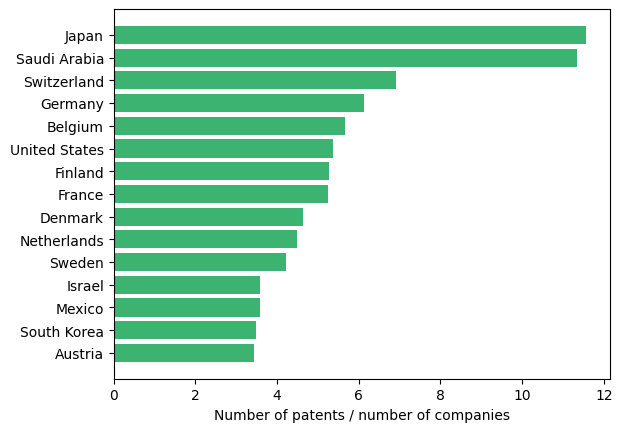

In [252]:
k = 15
top_k_spread = dict(list(companies_spread_dict.items())[:k])

fig, ax = plt.subplots()
ax.barh(list(top_k_spread.keys()),list(top_k_spread.values()), color = 'mediumseagreen')
ax.set_xlabel("Number of patents / number of companies")
ax.invert_yaxis()

## Danske virksomheder EXCEL ARK MED OPSLAG

In [256]:
DK_companies = pd.DataFrame(companies_grouped.loc["Denmark"])
DK_companies = DK_companies.rename(columns={0:"Antal Patenter"})

In [257]:
DK_companies = DK_companies.sort_values(by=["Antal Patenter"], ascending=False)
DK_companies_df = pd.DataFrame(DK_companies)
#convert_dataframe(DK_companies_df, "Danske_Virksomheder_patentansøgninger.xlsx")

## Gruppering af lande indenfor teknikområder

In [258]:
df_rådata['Affald'] = df_rådata['Affald'].str.replace("Y","Affald")
df_rådata['Klimatilpasning'] = df_rådata['Klimatilpasning'].str.replace("Y","Klimatilpasning")
df_rådata['Luft'] = df_rådata['Luft'].str.replace("Y","Luft")
df_rådata['Natur'] = df_rådata['Natur'].str.replace("Y","Natur")
df_rådata['Vand'] = df_rådata['Vand'].str.replace("Y","Vand")

In [259]:
cols = ["Affald", "Klimatilpasning", "Luft", "Natur", "Vand"]
Teknikområde =  df_rådata[cols].apply(lambda x: x.str.cat(sep=' '), axis=1)
df_rådata["Teknikområde"] = Teknikområde

In [260]:
vand = df_rådata.groupby(["person_ctry_code", "Vand"]).size()
vand.name = "vand"
affald = df_rådata.groupby(["person_ctry_code", "Affald"]).size()
affald.name = "affald"
klimatilpasning = df_rådata.groupby(["person_ctry_code", "Klimatilpasning"]).size()
klimatilpasning.name = "klimatilpasning"
luft = df_rådata.groupby(["person_ctry_code", "Luft"]).size()
luft.name = "luft"
natur = df_rådata.groupby(["person_ctry_code", "Natur"]).size()
natur.name = "natur"

#### Når der er nogen patenter som går over flere teknikområder, bliver de her talt med for hver gang de fremgår inden for et teknikområde. Så begge gange vil blive talt.

#### Nu er der både et dict som viser hvor mange samlede teknikområder de forskellige lande rækker sig over, og et dict som viser hvor mange patenter de forskellige lande har for hvert teknikområde (et dict for hvert område)

#### Mangler at dividere med 100000 for hver, så dette også fremgår

In [261]:
teknikområder_dict = {}
teknikområder = [vand, affald, klimatilpasning, luft, natur]

In [262]:
normed_vand = vand.reset_index()
normed_affald = affald.reset_index()
normed_klima = klimatilpasning.reset_index()
normed_luft = luft.reset_index()
normed_natur = natur.reset_index()
normed_teknikområder = [normed_vand,normed_affald,normed_klima,normed_luft,normed_natur]

i = 0
for teknikområde in normed_teknikområder:
    temp_list = []
    for country in teknikområde["person_ctry_code"]:
        temp_list.append(float(teknikområde[teknikområde["person_ctry_code"]==country][teknikområde.columns[2]]/float(pop[pop["Country/Territory"]==country]["Population / 100000"])))
    teknikområde["teknikområder/(inhabitants/100000)"] = temp_list
    i+=1

In [263]:
for country in countries:
    total = 0
    for teknikområde in teknikområder:
        try:
            total += teknikområde[country].sum()
        except:
            total += 0
    teknikområder_dict[country] = total

In [264]:
sorted_dict = dict(sorted(teknikområder_dict.items()))

In [265]:
def set_per_100000(data, set_p = True):
    final_data = []
    final_namelist = []
    temp_data = list(data.keys())
    for i in range(len(temp_data)):
        if type(data) == pd.core.series.Series:
            country = temp_data[i][0]
            final_namelist.append(country)
        if type(data) == dict:
            country = temp_data[i]
            final_namelist.append(country)
        try:
            pop_100000 = float(pop[pop["Country/Territory"] == country]['Population / 100000'])
        except:
            print(country)
        if set_p:
            adjusted_patents = float(data[country])/pop_100000
        else: 
            adjusted_patents = float(data[country])
        final_data.append(adjusted_patents)
    return final_namelist, final_data
            
    
    

In [266]:
def create_feature_frame(list_of_data, list_of_names_str, set_p = True):
    final_df = pd.DataFrame()
    for i in range(len(list_of_data)):
        temp_dataframe = pd.DataFrame()
        temp_dataframe["country"], temp_dataframe[list_of_names_str[i]] = set_per_100000(list_of_data[i], set_p)
        if i == 0:
            final_df = temp_dataframe
        else:
            final_df = pd.merge(final_df, temp_dataframe, "outer")
        final_df = final_df.replace(np.nan, 0)
    return final_df
    

#### Her har jeg forsøgt mig med unsupervised learning for at finde ud af hvilke grupperinger der er blandt landende og deres patentansøgninger inden for de forskellige teknikområder. Det viser sig med denne fremgangsmåde, at den blot har kigget på mængden af patenter i det hele taget, og ikke så meget på hvilke teknikområder er blevet prioriseret. Dette vil blive kigget på efter.

In [267]:
patents = df_rådata.groupby(["person_ctry_code"]).size()

In [268]:
teknikområder2 = [vand, affald, klimatilpasning, luft, natur, patents]
for teknik in teknikområder2:
    for haven in tax_havens:
        if haven in teknik:
            teknik.drop(haven, inplace=True)


In [270]:
patents_dict = patents.to_dict()
x2 = create_feature_frame([vand, luft, affald, klimatilpasning, natur, patents_dict], ["Vand", "Luft", "Affald", "Klimatilpasning", "Natur", "antal patenter"], set_p = False)

In [273]:
#convert_dataframe(x2, "teknikområde_opdelinger.xlsx")

In [272]:
patents_dict = patents.to_dict()
x = create_feature_frame([vand, luft, affald, klimatilpasning, natur, patents_dict], ["Vand", "Luft", "Affald", "Klimatilpasning", "Natur", "antal patenter"])

In [274]:
#convert_dataframe(x, "teknikområde_opdelinger_normed.xlsx")

In [240]:
x_temp = x[["Vand","Luft"]]
x_temp["sum"] = x_temp.sum(axis=1)
x_temp["country"] = x["country"]
x_temp = x_temp.sort_values(by="sum", ascending=False)
top_k = list(x_temp["country"][:2])
x_temp = x_temp.drop("sum", axis=1)
x_temp = x_temp.melt(id_vars=['country'], var_name='tech', value_name='pr')
# highlight_category = x_temp.loc[x_temp['Country'] == "Denmark", 'Country'].iloc[0]
# x_temp['Highlight'] = x_temp['country'].apply(lambda x: x == "Denmark")

C:\Users\Nedan\AppData\Local\Temp\ipykernel_15960\2597026131.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_k = list(x_temp["country"][:2])


In [243]:
single_country=True
select_country="Denmark"

In [268]:
x_temp = x[["Vand","Luft"]]
x_temp["sum"] = x_temp.sum(axis=1)
x_temp["country"] = x["country"]
x_temp = x_temp.sort_values(by="sum", ascending=False)
x_temp.reset_index(drop=True, inplace=True)
if single_country:
    mark2 = x_temp[x_temp["country"]==select_country].index[0]+6
if not single_country:
    mark2 = st.session_state.number_of_instances
top_k = list(x_temp["country"][:mark2])
x_temp = x_temp.drop("sum", axis=1)
x_temp = x_temp.melt(id_vars=['country'], var_name='tech', value_name='patents')
x_temp = x_temp[x_temp["country"].isin(top_k)]
x_temp["country"] = x_temp['country'].str.strip()

In [269]:
x_temp

,country,tech,patents
0,Switzerland,Vand,15.857267
1,Denmark,Vand,9.605150
2,Finland,Vand,9.511356
3,Sweden,Vand,6.853505
4,Germany,Vand,5.695105
5,Japan,Vand,4.111279
6,United States,Vand,6.051024
88,Switzerland,Luft,15.811503
89,Denmark,Luft,7.735121
90,Finland,Luft,7.219246


In [261]:
x_temp = x[["Vand","Luft"]]
x_temp["sum"] = x_temp.sum(axis=1)
x_temp["country"] = x["country"]
x_temp = x_temp.sort_values(by="sum", ascending=False)

In [265]:
x_temp[x_temp["country"]==select_country].index[0]

16

In [262]:
mark2 = x_temp[x_temp["country"]==select_country].index[0]+6

In [263]:
mark2

22

In [250]:
top_k = list(x_temp["country"][:mark2])

C:\Users\Nedan\AppData\Local\Temp\ipykernel_15960\1103954976.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_k = list(x_temp["country"][:mark2])


In [258]:
x_temp["country"][:7]

C:\Users\Nedan\AppData\Local\Temp\ipykernel_15960\3758345972.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  x_temp["country"][:7]


53      Switzerland
16          Denmark
20          Finland
52           Sweden
22          Germany
32            Japan
59    United States
Name: country, dtype: object

In [259]:
top_k

['Switzerland',
 'Denmark',
 'Finland',
 'Sweden',
 'Germany',
 'Japan',
 'United States',
 'Netherlands',
 'Israel',
 'Norway',
 'Austria',
 'Belgium',
 'France',
 'Canada',
 'San Marino',
 'Andorra',
 'Ireland',
 'Italy',
 'Cayman Islands',
 'Namibia',
 'Slovenia',
 'Malta']

In [229]:
x_temp = x_temp[x_temp["country"].isin(top_k)]

In [230]:
x_temp["country"] = x_temp['country'].str.strip()

In [265]:
x_k = x.sort_values(by="antal patenter", ascending=False)[:20]

In [273]:
y = x_k.drop(["country"], axis = 1)
y = y.sort_values(by="antal patenter", ascending=False)
y = y.drop(["antal patenter"], axis = 1)

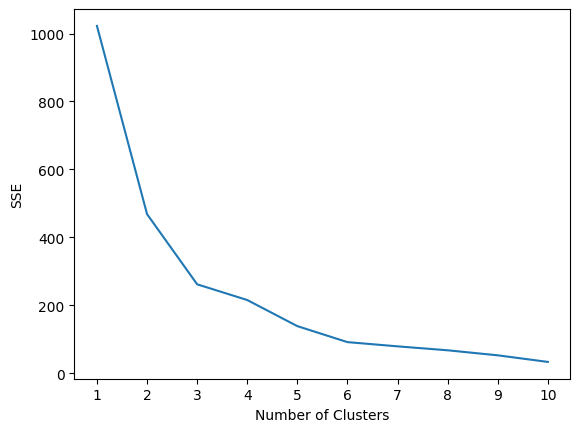

In [274]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(y)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [275]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(y)

KMeans(init='random', n_clusters=3, n_init=10, random_state=1)

In [276]:
y["country"] = x_k["country"]
y["cluster"] = kmeans.labels_
y

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
53,15.857267,15.811503,13.889410,4.484884,0.469082,Switzerland,0
20,9.511356,7.219246,20.989957,1.534090,1.353609,Finland,0
16,9.605150,7.735121,8.245129,2.618041,0.714011,Denmark,2
39,6.723976,4.845134,7.116824,3.182644,0.438396,Netherlands,2
52,6.853505,8.332269,4.644837,1.175428,0.369691,Sweden,2
22,5.695105,8.154028,5.161339,1.151496,0.173924,Germany,2
41,5.962109,4.747605,3.790723,4.213959,1.251307,Norway,2
59,6.051024,5.701028,5.127555,1.757073,0.354725,United States,2
30,9.194198,2.268123,2.743876,4.547311,0.719161,Israel,2
32,4.111279,9.579538,4.082236,0.615562,0.243643,Japan,2


In [277]:
y[y["cluster"]==2]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
16,9.605150,7.735121,8.245129,2.618041,0.714011,Denmark,2
39,6.723976,4.845134,7.116824,3.182644,0.438396,Netherlands,2
52,6.853505,8.332269,4.644837,1.175428,0.369691,Sweden,2
22,5.695105,8.154028,5.161339,1.151496,0.173924,Germany,2
41,5.962109,4.747605,3.790723,4.213959,1.251307,Norway,2
59,6.051024,5.701028,5.127555,1.757073,0.354725,United States,2
30,9.194198,2.268123,2.743876,4.547311,0.719161,Israel,2
32,4.111279,9.579538,4.082236,0.615562,0.243643,Japan,2
6,2.745384,4.238186,6.434493,2.702487,0.231642,Belgium,2
4,2.997891,4.742932,6.454415,0.592867,0.033558,Austria,2


In [278]:
y[y["cluster"]==1]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
21,3.103984,3.512484,4.052509,0.676192,0.287807,France,1
9,3.965744,2.283228,3.528862,0.876364,0.369269,Canada,1
28,2.408867,1.493099,2.090339,0.477792,0.079632,Ireland,1
10,2.910954,0.000000,2.910954,0.000000,0.000000,Cayman Islands,1
31,1.720941,1.441457,2.307009,0.287953,0.132119,Italy,1
1,5.011024,0.000000,0.000000,0.000000,0.000000,Andorra,1
38,1.207630,1.012851,1.012851,0.740160,0.116867,Namibia,1
37,1.312616,0.750067,2.062683,0.187517,0.187517,Malta,1


In [279]:
y[y["cluster"]==0]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
53,15.857267,15.811503,13.889410,4.484884,0.469082,Switzerland,0
20,9.511356,7.219246,20.989957,1.534090,1.353609,Finland,0


#### Her vil der så bliver kigget på hvordan kmeans vil finde grupperinger, hvis man i stedet sammenligner landende på baggrund af deres prioritering af de forskellige teknikområder ud af det samlede antal patenter. Her skal vi igen tænke på at der godt kan være flere teknikområder end der er patenter, fordi nogen patenter rækker over flere teknikområder.

#### Starter da med at dividere antallet af patenter indenfor de forskellige teknikområder med den totale mængde af patenter for det pågældende land.

In [280]:
patents_dict = patents.to_dict()
z = create_feature_frame([vand, luft, affald, klimatilpasning, natur, patents_dict], ["Vand", "Luft", "Affald", "Klimatilpasning", "Natur", "antal patenter"], set_p = False)
z = z[["Vand", "Luft", "Affald", "Klimatilpasning", "Natur"]].div(z["antal patenter"], axis=0)


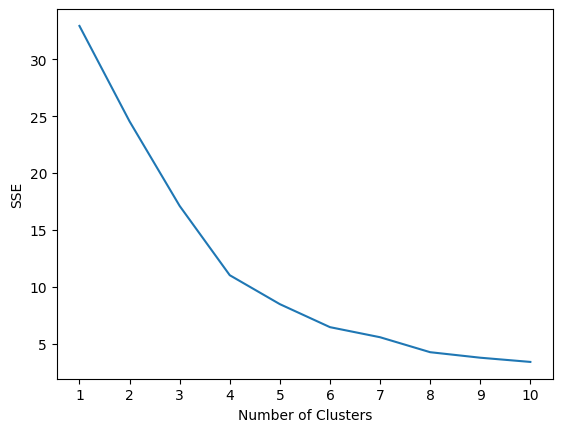

In [282]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(z)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [283]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(z)

KMeans(init='random', n_clusters=5, n_init=10, random_state=1)

In [284]:
z["country"] = x["country"]
z["cluster"] = kmeans.labels_
z

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
0,1.000000,0.000000,0.000000,0.000000,0.000000,Algeria,0
1,1.000000,0.000000,0.000000,0.000000,0.000000,Andorra,0
2,0.150000,0.150000,0.450000,0.250000,0.000000,Argentina,2
3,0.210526,0.157895,0.350877,0.315789,0.017544,Australia,2
4,0.223893,0.354219,0.482038,0.044277,0.002506,Austria,2
...,...,...,...,...,...,...,...
83,0.000000,0.000000,0.000000,1.000000,0.000000,Gabon,1
84,0.000000,0.000000,0.000000,1.000000,1.000000,Madagascar,1
85,0.000000,0.000000,0.000000,1.000000,0.000000,Philippines,1
86,0.000000,0.000000,0.000000,1.000000,0.000000,Uzbekistan,1


In [285]:
z[z["country"]=="Denmark"]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
16,0.369764,0.297775,0.317408,0.100785,0.027487,Denmark,2


In [286]:
z[z["cluster"]==2]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
2,0.150000,0.150000,0.450000,0.250000,0.000000,Argentina,2
3,0.210526,0.157895,0.350877,0.315789,0.017544,Australia,2
4,0.223893,0.354219,0.482038,0.044277,0.002506,Austria,2
6,0.178372,0.275362,0.418060,0.175585,0.015050,Belgium,2
7,0.088235,0.264706,0.382353,0.294118,0.000000,Brazil,2
8,0.130435,0.304348,0.478261,0.086957,0.000000,Bulgaria,2
9,0.415871,0.239433,0.370057,0.091901,0.038724,Canada,2
10,0.500000,0.000000,0.500000,0.000000,0.000000,Cayman Islands,2
12,0.337500,0.350000,0.306250,0.125000,0.012500,China,2
13,0.307692,0.307692,0.307692,0.153846,0.000000,Croatia,2


In [287]:
z[z["cluster"]==4]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
61,0.0,1.000000,0.000000,0.000000,0.0,Iceland,4
62,0.0,1.000000,0.000000,0.000000,0.0,Malaysia,4
63,0.0,0.769231,0.307692,0.038462,0.0,Mexico,4
65,0.0,1.000000,0.000000,0.000000,0.0,NaN,4


In [288]:
z[z["cluster"]==3]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
11,0.25,0.000000,0.750000,0.0,0.0,Chile,3
64,0.00,0.166667,0.833333,0.0,0.5,Morocco,3
66,0.00,0.000000,1.000000,0.0,0.0,Barbados,3
67,0.00,0.000000,1.000000,0.0,0.0,Colombia,3
68,0.00,0.000000,1.000000,0.0,0.0,Curacao,3
70,0.00,0.000000,1.000000,0.0,0.0,Jamaica,3
71,0.00,0.000000,1.000000,0.0,0.0,Kazakhstan,3
73,0.00,0.000000,1.000000,0.0,0.0,Panama,3
74,0.00,0.000000,1.000000,0.0,0.0,Paraguay,3
75,0.00,0.000000,1.000000,0.0,0.0,Peru,3


In [289]:
z[z["cluster"]==1]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
72,0.0,0.0,1.0,1.0,0.0,Lebanon,1
80,0.0,0.0,0.0,1.0,0.0,Bangladesh,1
81,0.0,0.0,0.0,1.0,0.0,Botswana,1
82,0.0,0.0,0.0,1.0,0.0,Faroe Islands,1
83,0.0,0.0,0.0,1.0,0.0,Gabon,1
84,0.0,0.0,0.0,1.0,1.0,Madagascar,1
85,0.0,0.0,0.0,1.0,0.0,Philippines,1
86,0.0,0.0,0.0,1.0,0.0,Uzbekistan,1


In [290]:
z[z["cluster"]==0]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
0,1.00,0.0,0.00,0.00,0.0,Algeria,0
1,1.00,0.0,0.00,0.00,0.0,Andorra,0
5,1.00,0.0,0.00,0.00,0.0,Bahamas,0
17,1.00,0.0,0.00,0.00,0.0,Egypt,0
19,1.00,0.0,0.00,0.00,0.0,Ethiopia,0
24,1.00,0.0,0.00,0.00,0.0,Guernsey,0
29,1.00,0.0,0.00,0.00,0.0,Isle of Man,0
33,1.00,0.0,0.00,0.00,0.0,Jordan,0
34,1.00,0.0,0.00,0.00,0.0,Kuwait,0
40,0.75,0.0,0.25,0.25,0.0,New Zealand,0


In [76]:
z[z["cluster"]==3]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
9,0.415871,0.239433,0.370057,0.091901,0.038724,Canada,3
12,0.337500,0.350000,0.306250,0.125000,0.012500,China,3
13,0.307692,0.307692,0.307692,0.153846,0.000000,Croatia,3
16,0.369764,0.297775,0.317408,0.100785,0.027487,Denmark,3
21,0.291485,0.329846,0.380558,0.063499,0.027027,France,3
22,0.306303,0.438552,0.277595,0.061931,0.009354,Germany,3
27,0.388889,0.222222,0.277778,0.166667,0.055556,India,3
28,0.412969,0.255973,0.358362,0.081911,0.013652,Ireland,3
30,0.533719,0.131663,0.159281,0.263969,0.041747,Israel,3
32,0.239238,0.557439,0.237548,0.035820,0.014178,Japan,3


In [68]:
Klima_cluster = list(z[z["cluster"]==4]["country"])
Vand_cluster = list(z[z["cluster"]==2]["country"])
Luft_cluster = list(z[z["cluster"]==0]["country"])
Affald_cluster = list(z[z["cluster"]==1]["country"])
Naturish_cluster = list(z[z["cluster"]==3]["country"])

#### Vil gerne give dem longitude og latitude, men pt. i det data jeg har hentet, er der en del uoverenstemmelser mellem navnene i de lande jeg har i mit data og det hentede. (Det virker også til at der er en del af landende som ikke indgår i dataen).

In [ ]:
coords_all = pd.read_csv("countries.csv")
coords_subset = pd.DataFrame()
coords_subset["country"] = x["country"]

In [ ]:
coords_all

In [ ]:
Longitudes = np.array([])
Latitudes = np.array([])

for country in coords_subset["country"]:
    try:
        Longitudes = np.append(Longitudes,float(coords_all[coords_all["Country"] == country]["Longitude"]))
        
    except:
        Longitudes = np.append(Longitudes, "Missing")
        
    try:
        Latitudes = np.append(Latitudes,float(coords_all[coords_all["Country"] == country]["Latitude"]))
    
    except:
        Latitudes = np.append(Latitudes, "Missing")


In [ ]:
coords_subset["Latitudes"] = Latitudes
coords_subset["Longitudes"] = Longitudes

In [ ]:
coords_subset[coords_subset["Longitudes"] == "Missing"]

#### Mangler at få koordinater på: Dette kan gøres direkte i CSV fil (USA?) Hvor præcist

In [ ]:
coords_subset[coords_subset["Longitudes"] == "Missing"]["country"]

In [ ]:
coords_subset["Cluster"] = z["cluster"]
coords_subset.to_csv("subset_with_coords.csv", index=False)

In [277]:
ha = convert_excel("teknikområde_opdelinger_normed.xlsx", sheet_name="Sheet1")
ha = ha.rename(columns={"Natur": "Soil, Water & Nature", "Luft": "Air", "Vand": "Water in the technosphere", "Klimatilpasning": "Climate adaptation", "Affald": "Waste, Resources & Materials"})

The first 5 rows of the loaded data:


,country,Vand,Luft,Affald,Klimatilpasning,Natur,antal patenter
0,Algeria,0.004454,0.000000,0.000000,0.000000,0.000000,0.004454
1,Andorra,5.011024,0.000000,0.000000,0.000000,0.000000,5.011024
2,Argentina,0.006592,0.006592,0.019776,0.010987,0.000000,0.043946
3,Australia,0.045841,0.034381,0.076402,0.068762,0.003820,0.217745
4,Austria,2.997891,4.742932,6.454415,0.592867,0.033558,13.389835


In [278]:
x = ha

In [ ]:
select

In [292]:
x_temp = x[["Climate adaptation", "Air", "Soil, Water & Nature"]]
x_temp["sum"] = x_temp.sum(axis=1)
x_temp["country"] = x["country"]
x_temp = x_temp.sort_values(by="sum", ascending=False)
x_temp.reset_index(drop=True, inplace=True)
if single_country:
    mark2 = x_temp[x_temp["country"]==select_country].index[0]+6
if not single_country:
    mark2 = st.session_state.number_of_instances
top_k = list(x_temp["country"][:mark2])
x_temp = x_temp.drop("sum", axis=1)
x_temp = x_temp.melt(id_vars=['country'], var_name='tech', value_name='patents')
x_temp = x_temp[x_temp["country"].isin(top_k)]
x_temp["country"] = x_temp['country'].str.strip()
x_temp['order'] = x_temp['tech'].replace({val: i for i, val in enumerate(['Soil, Water & Nature', 'Air', 'Water in the technosphere', 'Climate adaptation', "Waste, Resources & Materials"])})

In [293]:
x_temp

,country,tech,patents,order
0,Switzerland,Climate adaptation,4.484884,3
1,Denmark,Climate adaptation,2.618041,3
2,Japan,Climate adaptation,0.615562,3
3,Norway,Climate adaptation,4.213959,3
4,Finland,Climate adaptation,1.534090,3
5,Sweden,Climate adaptation,1.175428,3
6,Germany,Climate adaptation,1.151496,3
88,Switzerland,Air,15.811503,1
89,Denmark,Air,7.735121,1
90,Japan,Air,9.579538,1
